# 銀イルカの3人のセリフをスクレイピングして，文書を形態素解析して全文書から分散表現を得る（可視化もする）

## 概要

まずwikiとかから3人のセリフをスクレイピングする． 

スクレイピングした3人の全セリフ（文書）をword2vecで学習し分散表現モデルを構築し，単語についての固定長ベクトルが得られるようにする．

ある単語s（producerなど）を入力した時に単語sとコサイン類似度が高い上位n単語を抽出．

n語の単語の固定長ベクトルを次元削減して2次元座標上にプロットすることで，単語ごとの類似度を（意味のあるまとまった形として）可視化する

## 方針

1. 銀イルカ3人のセリフをスクレイピング  
2. doc2vecで単語の分散表現を学習
3. t-sneとumapで可視化

## requirementis

- python 3.7.1
- pipenv
- mecab
    - ipa
    - neologd
- numpy
- pandas
- scipy
- scikit-learn
- umap
- gensim
- matplotlib
- seaborn

（多すぎ・・・）

usage: `pipenv install`  
python, pipenvなど書くライブラリのインストール方法は省略

## import するものとかオプションとか

In [1]:
import glob
import re
import time
import random
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
import MeCab

In [3]:
from gensim import corpora, models

In [4]:
from gensim.models import word2vec

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

In [6]:
import umap
import matplotlib.cm as cm
from scipy.sparse.csgraph import connected_components

from sklearn.manifold import TSNE
from pylab import rcParams
import seaborn as sns
sns.set()

In [7]:
# graph関係
rcParams['figure.figsize'] = 20, 12
rcParams['font.size'] = 20
rcParams["font.family"] = "IPAPGothic"

In [8]:
# pandasの表示についてのオプション
pd.options.display.max_rows = 500
pd.options.display.max_columns = 20 

## スクレイピング

### アイドルの設定

deresute id
- chieri : 112
- minami : 185
- yui    : 246
- sae    : 132
- hotaru : 161
- yoshino: 262

In [9]:
# idol = ["chieri", "112", "緒方智絵里"]
# idol = ["yui", "246", "大槻唯"]
idol = ["minami", "185", "新田美波"]

## デレステセリフのスクレイピング

In [10]:
def get_quotes_sute(q):
    """
    デレステで公開されている各アイドルのセリフデータを取得する
    [arg]
    q: int
    [ret]
    df: DataFrame
    """
    html = f"https://starlight.kirara.ca/char/{q}"
    r = requests.get(html)
    r.encoding = r.apparent_encoding
    soup = BeautifulSoup(r.text, "lxml")
    texts = soup.find_all("span")
    corpus = []
    for text in texts:
        corpus.append(text.text)
    df = pd.DataFrame(corpus)
    #df[0].value_counts().head(10) # 値の出現頻度をカウント
    df = df[~df.duplicated()] # 重複行をdataframeから除外
    df = df[~df[0].str.match("^[\s|a-zA-Z|<|\+|\d$]")] # 正規表現にマッチするものを除外
    df = df[df[0] != ""]
    return df.reset_index(drop=True)

## モバマスセリフのスクレイピング

In [11]:
def get_quotes_moba(query="緒方智絵里", debug=False):
    """
    モバマスで公開されているセリフ（含 アイドル名、カード名 など）
    をスクレイピングして pandas dataframe にする
    
    [args]
    query: str 省略すると 緒方智絵里 のセリフをスクレイピングする
    debug: Bool Trueにするとスクレイピング数を上限2にする。それだけ もっと良い使い方あるはず...
    [ret]
    df: DataFrame
    """
    
    html = f"https://icws.indigo-bell.com/search?q={query}&st=n"
    r = requests.get(html)
    r.encoding = r.apparent_encoding
    soup = BeautifulSoup(r.text, "lxml")
    a = soup.find("a", string="Last　»").get("href")
    if debug == True:
        n = 2
    else:
        n = int(re.search(r"page=(\d+)&", a).group(1)) # クロールするページ数
    
    df = pd.DataFrame()
    for i in range(n): # セリフが登録されてるページ分ループする
        print(f"crawling page: {i + 1}/{n}")
        html = f"https://icws.indigo-bell.com/search?page={i + 1}&q={query}&st=n"
        r = requests.get(html)
        r.encoding = r.apparent_encoding
        soup = BeautifulSoup(r.text, "lxml")
        table = soup.find_all("tbody",class_="result")[0]
        rows = table.find_all("tr")
        tmp = []
        tm = 5 + random.randint(0, 5)

        for row in rows:
            cell_txt = []
            for cell in row.find_all(["td", "th"]):
                cell_txt.append(cell.text)
            tmp.append(cell_txt)
        df = df.append(tmp)
        #print(f"sleep: {tm}")
        if i != (n - 1):
            time.sleep(tm)
        else:
            continue
    return df.reset_index(drop=True) # indexを振り直してもとのindexも削除

In [12]:
# data/に idol_moba.csv idol_dere.csvが両方なかったらスクレイピングを実行する
# あったらdataframeにする
if not glob.glob(f"data/{idol[0]}_moba.csv") and not glob.glob(f"data/{idol[0]}_dere.csv"):
    print("nai")
    aa = get_quotes_sute(int(idol[1]))
    bb = get_quotes_moba(query=idol[2])
    aa.to_csv(f"data/{idol[0]}_moba.csv")
    bb.to_csv(f"data/{idol[0]}_dere.csv")
else:
    print("aru")
    aa = pd.read_csv(f"data/{idol[0]}_moba.csv", index_col=0)
    bb = pd.read_csv(f"data/{idol[0]}_dere.csv", index_col=0)

aru


In [13]:
aa.head(10)

,0
0,アイドルマスター シンデレラガールズ スターライトステージ!
1,おはようございます。あ、プロデューサーさん、スーツにホコリが
2,お昼ごはん、またコンビニ弁当ですか？今度お弁当作ってきましょうか
3,遅くまでごくろうさまです。私も負けずに頑張らなくちゃ !
4,何事も経験です ! プロデューサーさん、LIVEも経験ですね !
5,ちひろさんが呼んでいましたけど…何のご用でしょうね
6,プロデューサーさんに申請がきてるみたいです。誰からでしょう？
7,イベントやってるみたいですね。ぜひ、勉強させてください !
8,プレゼントが届いてるみたいです。なんでしょう？ワクワクしますね
9,プロデューサーさんも休憩かな？ふふっ、仕事ばかりでお疲れですよね


In [14]:
bb.head(10)

,0,1,2,3
0,新田美波,新田美波,アイドルコメント,ふふっ、私がアイドルなんてなんだかドキドキします。あ、でもアイドルになったら学業に響いたりし...
1,新田美波,新田美波,マイスタジオ,アイドルになるのも一つの勉強と思って、色々チャレンジしたいですね
2,新田美波,新田美波,マイスタジオ,家族にアイドル応援されちゃって
3,新田美波,新田美波,マイスタジオ,おはよう。今日も頑張ろうねっ!
4,新田美波,新田美波,マイスタジオ,勉強もスポーツも、大好きですっ
5,新田美波,新田美波,お仕事,皆さん、優しい方で嬉しいです
6,新田美波,新田美波,お仕事,プロデューサーさん、わたしもっといろんな仕事がしたいなぁ…?
7,新田美波,新田美波,お仕事,いろんなコト勉強してきますねっ
8,新田美波,新田美波,お仕事,ミスコンの審査より緊張しちゃう…
9,新田美波,新田美波,お仕事（親愛度UP）,アイドルって皆に愛されるお仕事なんですねっ、○○さん


## モバ，ステの結合と正規化

In [15]:
# とてもしょーもない処理(intをわざわざstrとしてる)
bb["3"] = bb["3"].str.replace("○○", "") # OO (プロデューサー名)部分を落とす
bb["3"] = bb["3"].str.replace("〇〇", "") # OO (プロデューサー名)部分を落とす
# aa + bb のコーパスを作る
docs = pd.Series()
docs = pd.concat([aa["0"], bb["3"]])
docs = docs.str.replace("プロデューサー", "PRODUCER")
docs = docs.str.replace("[Producer]", "PRODUCER", regex=False)
docs = docs.reset_index(drop=True)

/home/wani/dere/idol_info/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


In [16]:
docs.to_csv(f'data/{idol[0]}_corpus.csv')

## 形態素解析

mecabを使う。インストールしていなければめかぶをインストール

neeologdまでインストールする手順はの参考は
- [ubuntu 18.10 に mecab をインストール](https://qiita.com/ekzemplaro/items/c98c7f6698f130b55d53)
- [WSLでMeCabとJupyter Notebookを動かす](https://qiita.com/hironobukawaguchi3/items/61a8664dd26c1da66880)
- [MecabをPythonで使うまで](https://qiita.com/Sak1361/items/47e9ec464ccc770cd65c)

---

$ mecab -d /usr/lib/mecab/dic/mecab-ipadic-neologd


wsl in ubuntu だとうまく動作しない可能性あり．

In [17]:
mecab_path = !echo `mecab-config --dicdir`
def extractNoun(text, mecab_mode = rf'-Owakati -d {mecab_path[0]}/mecab-ipadic-neologd', noun="名詞"):
    """
    [arg]: str
    [ret]: str
    """
    tagger = MeCab.Tagger(mecab_mode)
    node = tagger.parseToNode(text)
    keywords = []
    while node:
        surface = node.surface # 表層形を表示(str)
        meta = node.feature.split(",") # ['記号', '読点', '*', '*', '*', '*', '、', '、', '、']
        if meta[0] == noun:
            keywords.append(node.surface)
        node = node.next # 次のノードのアドレスを指定
    return " ".join(keywords)

def tokenize(text, wakati=True, dic="neologd"):
    """
    テキストを形態素解析して分かち書きする
    [arg]
    text: str
    [ret]
    term: str
    """
    if dic == "neologd":
        mecab_mode = MeCab.Tagger(rf'-Owakati -d {mecab_path[0]}/mecab-ipadic-neologd') # debugging
    else:
        mecab_mode = MeCab.Tagger(r'-Owakati')
    if wakati == True: # 分かち書きしたものをそのまま取り出す
        term = mecab_mode.parse(text).strip()
    else: # 品詞で
        term = extractNoun(text, mecab_mode)
    return term

### mecabの動作チェック

In [18]:
text = "テキストを形態素解析して分かち書きする"
print(extractNoun(text))

テキスト 形態素解析 分かち書き


In [19]:
print(f'ipa-dic    ： {tokenize("特急はくたか", dic = "ipa")}')
print(f'neologd-dic： {tokenize("特急はくたか")}')

ipa-dic    ： 特急 は く た か
neologd-dic： 特急 はくたか


うまくうごいてそう

## 文章解析

In [20]:
docs_list = [extractNoun(row).split() for row in docs]
dic = corpora.Dictionary(docs_list)
dic.save_as_text(f'./data/{idol[0]}_text.dict')  # 保存

In [21]:
#gensim.corpora.Dictionary.load_from_text(f'./data/{idol[0]}_text.dict')  # 次回からファイルロード可

In [22]:
print(len(dic)) # dictionaryに登録された単語(形態素)数

2000


In [23]:
# 単語出現頻度を数える
# 余談: bashだと $ sort -t$'\t' -k3 -nr text.dict で単語とその出現頻度回数カウントできる
from collections import defaultdict
freq = defaultdict(int)

for text in docs_list:
    for token in text:
        freq[token] += 1
# print(sorted(freq.items(), key=lambda x:x[1], reverse=True)) # ソートされたterm freq
sorted_tf = sorted(freq.items(), key=lambda x:x[1], reverse=True)

In [24]:
i = 0
size = 20
graph_y_list = []
graph_x_list = []
for value, count in sorted_tf:
    if(i < size):
        graph_y_list.append(count)
        graph_x_list.append(value)
        i += 1

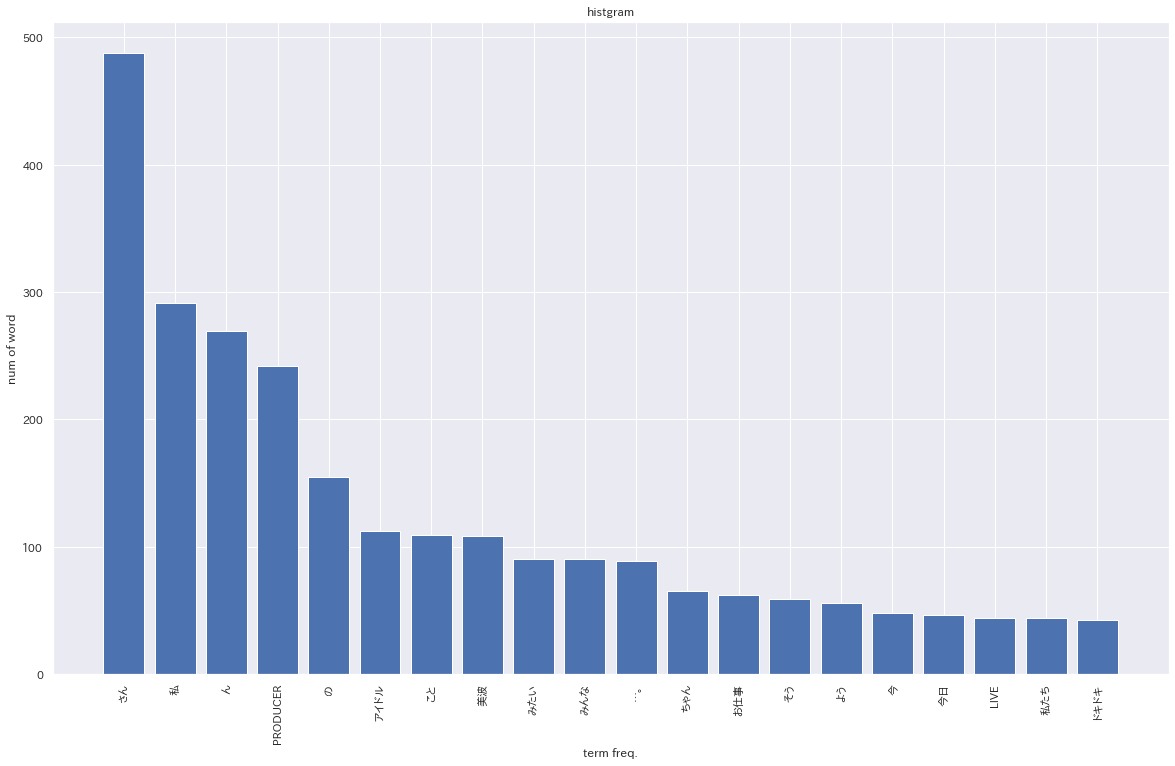

In [25]:
# グラフのパラメータ
plt.rcParams["font.family"] = "IPAPGothic"
plt.bar(height=graph_y_list, x=graph_x_list)
plt.title("histgram")
plt.xlabel('term freq.')
plt.ylabel('num of word')
plt.xticks(graph_x_list, rotation='vertical')
plt.grid(True, axis="y")

#グラフの表示
plt.show()

In [26]:
corpus = [dic.doc2bow(doc) for doc in docs_list] # コーパスの作成
corpora.MmCorpus.serialize(f'./data/{idol[0]}_text.mm', corpus)  # 保存

## word2vec モデルの作成

word2vecモデルの学習を行う際にword2vec.Word2Vecに食わせる文書は一文ごとの2次元配列

ex.

print(tokeData)  
[['4', '年', 'ぶり', 'ライナー'], ['エレン'], ['故郷']]

In [27]:
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# sentences = word2vec.Text8Corpus(w2v_corpus)

model = word2vec.Word2Vec(docs_list, size=300, min_count=2, window=15)
model.save(f"./data/{idol[0]}.w2v.model")

## 作成したword2vecモデルで単語の類似度を計算する

In [28]:
model = word2vec.Word2Vec.load(f"./data/{idol[0]}.w2v.model")

specword = "PRODUCER"

for result in model.wv.most_similar(positive=specword):
    print(result)

('美波', 0.9995512366294861)
('ん', 0.999549925327301)
('撮影', 0.999547004699707)
('杏', 0.9995424151420593)
('ー', 0.9995075464248657)
('みく', 0.9994860887527466)
('さん', 0.9994774460792542)
('智香', 0.9994572401046753)
('の', 0.9994544982910156)
('お仕事', 0.9994432926177979)


In [29]:
sim_words = [x[0] for x in model.most_similar(specword, topn=50)]
sim_words.append(specword)
labels = []
vecs = []
for word in sim_words:
    vecs.append(model[word])
    labels.append(word)

print(labels)

['美波', 'ん', '撮影', '杏', 'ー', 'みく', 'さん', '智香', 'の', 'お仕事', '…。', '志乃', '仁美', '楽しみ', '莉嘉', 'プール', 'ちゃん', '私', 'こと', 'それ', '世界', '次', '掃除', '自分', '今日', 'ため', 'アタシ', '人', '衣菜', '春', '李', 'そう', 'ふふ', 'みたい', '素敵', 'よう', '気持ち', 'みんな', '私たち', 'チャン', '一緒に', '楓', '桜', 'アイドル', '今年', '気', '季節', 'ドキドキ', '心', '今', 'PRODUCER']


/home/wani/dere/idol_info/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/home/wani/dere/idol_info/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## 次元削減手法を使ってword2vecのベクトルを2次元空間上にプロットしてみる

[ハンズオンUMAP, 学習する天然ニューラルネット - hatena blog](https://aotamasaki.hatenablog.com/entry/2018/07/28/220102)参考

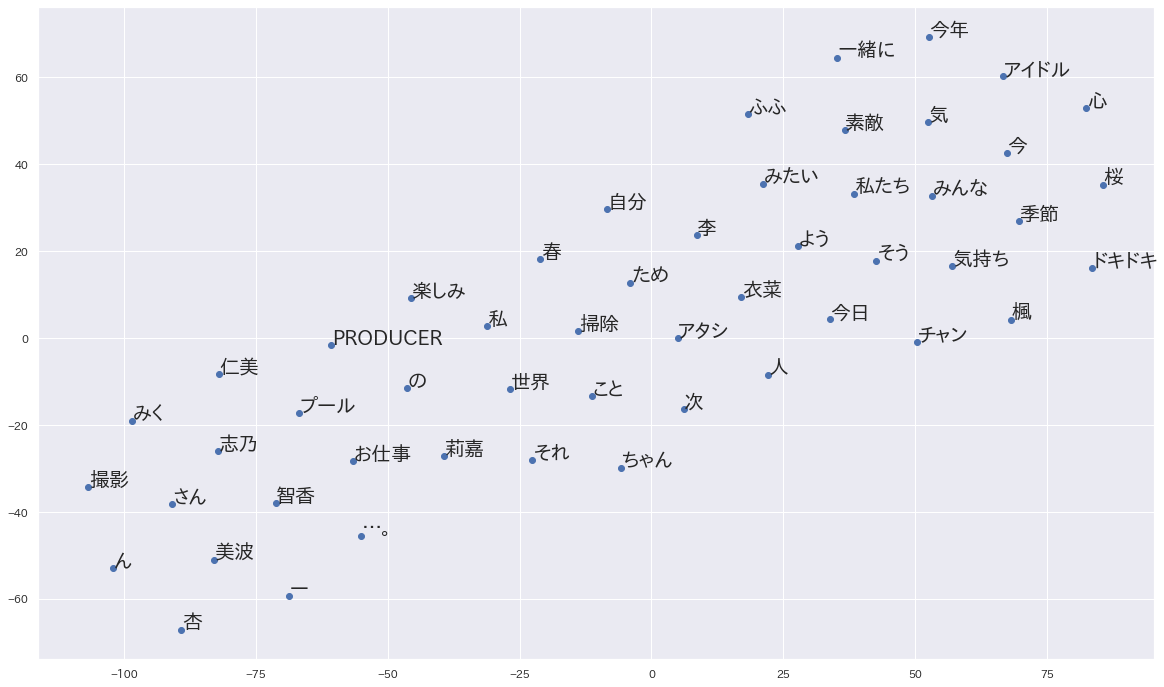

In [30]:
tsne = TSNE(random_state=428)
result = tsne.fit_transform(vecs)

plt.scatter(result[:,0], result[:,1], cmap=cm.tab10)

for i in range(len(result)):
    plt.annotate(labels[i],
                 xy=(result[i, 0]+0.1, result[i, 1]+0.1),
                 xytext=(0, 0),
                 textcoords='offset points')

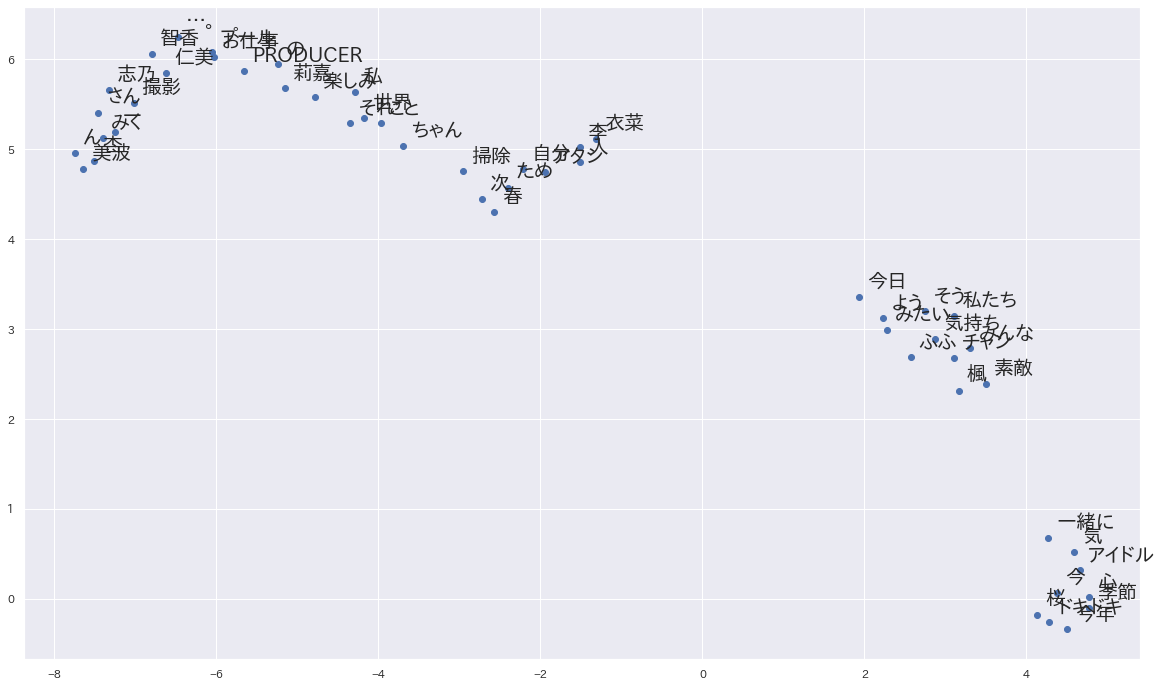

In [31]:
embedding = umap.UMAP().fit_transform(vecs)

plt.scatter(embedding[:,0], embedding[:,1], cmap=cm.tab10)

for i in range(len(embedding)):
    plt.annotate(labels[i],
                 xy=(embedding[i, 0]+0.1, embedding[i, 1]+0.1),
                 xytext=(0, 0),
                 textcoords='offset points')

## 智絵里，唯，美波のボイスにラベル付けしてword2vecを作成し，空間を2次元に圧縮して可視化

智絵里，唯，美波のボイスをすべて結合 -> 結合したコーパスを使用してword2vecモデルを学習させる -> key = PRODUCERにして各単語の分布を計算

In [32]:
chieri_corpus = pd.read_csv(f"data/chieri_corpus.csv", index_col=0)
yui_corpus = pd.read_csv(f"data/yui_corpus.csv", index_col=0)
minami_corpus = pd.read_csv(f"data/minami_corpus.csv", index_col=0)

In [33]:
concat_corpus = pd.concat([chieri_corpus, yui_corpus, minami_corpus])
concat_corpus = concat_corpus.reset_index(drop=True)
concat_corpus = concat_corpus["0"]

In [34]:
concat_corpus

0                          アイドルマスター シンデレラガールズ スターライトステージ!
1                       お、おはようございます。アーリーモーニングティー、いかがですか…？
2                       お昼だけど…もうちょっとだけ…午後のレッスンの予習をしなくっちゃ…
3                       ふぁぁ…こんな時間までお疲れさまです。ホットミルク、飲みますか…？
4                       PRODUCERさん…もしお暇なら、私…ステージに、立ちたい…です
                              ...                        
4532    あはっ、さんに選んでもらえるなんて嬉しいです♪あ、ちなみに以前大学のミスコンでは優勝出来たん...
4533                                             さん、こんばんは
4534    いつもクリスマスは友人や家族とパーティーをするんです。でも、今年はちょっとだけ、特別な夜にな...
4535    いつもパパや弟にあげてるんですけど…今年はさんにも渡します。それに…ちょっとだけ特別なチョコ...
4536    ミスコンの一票とは比べ物にならないくらい、さんの一票が、嬉しいです。ありがとうございます、ふふっ♪
Name: 0, Length: 4537, dtype: object

In [35]:
docs_list = [extractNoun(row).split() for row in concat_corpus]
dic = corpora.Dictionary(docs_list)
dic.save_as_text(f'./data/corpus_text.dict')  # 保存

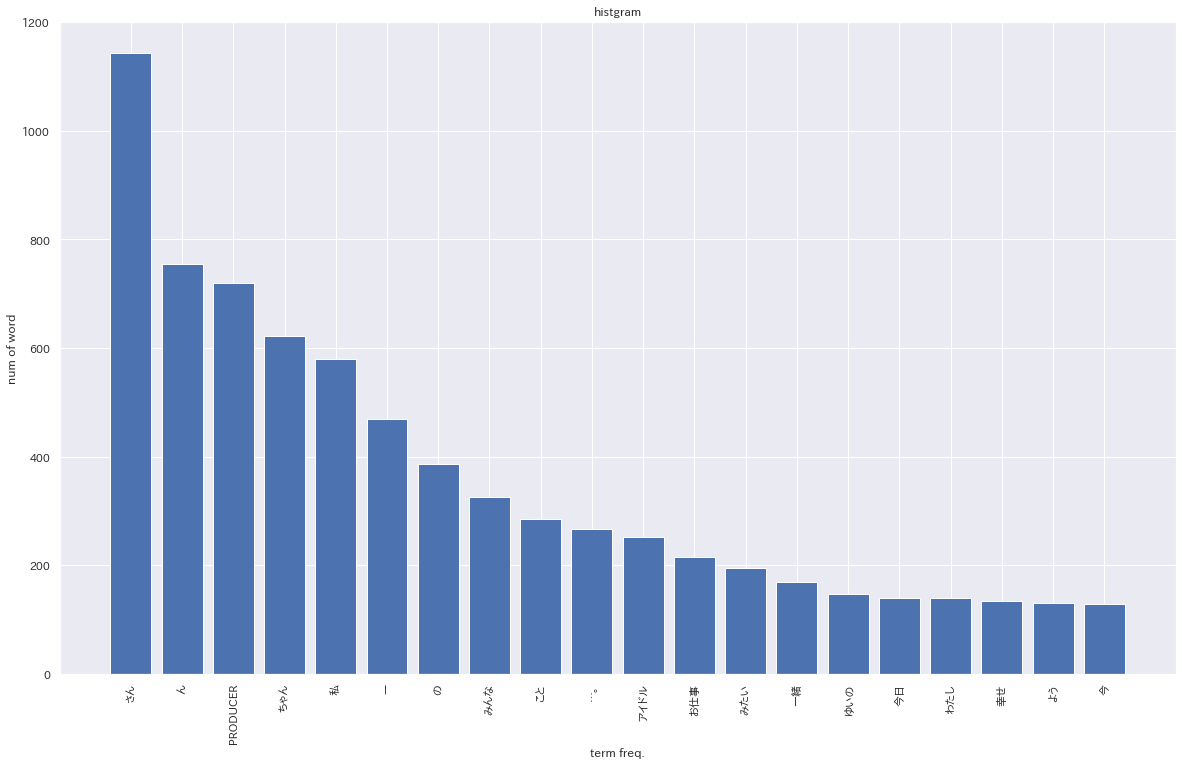

In [36]:
freq = defaultdict(int)

for text in docs_list:
    for token in text:
        freq[token] += 1
# print(sorted(freq.items(), key=lambda x:x[1], reverse=True)) # ソートされたterm freq
sorted_tf = sorted(freq.items(), key=lambda x:x[1], reverse=True)

i = 0
size = 20
graph_y_list = []
graph_x_list = []
for value, count in sorted_tf:
    if(i < size):
        graph_y_list.append(count)
        graph_x_list.append(value)
        i += 1

# グラフのパラメータ
plt.rcParams["font.family"] = "IPAPGothic"
plt.bar(height=graph_y_list, x=graph_x_list)
plt.title("histgram")
plt.xlabel('term freq.')
plt.ylabel('num of word')
plt.xticks(graph_x_list, rotation='vertical')
plt.grid(True, axis="y")

#グラフの表示
plt.show()

In [37]:
exp = "3idols"
model = word2vec.Word2Vec(docs_list, size=300, min_count=5, window=15)
model.save(f"./data/{exp}.w2v.model")

In [38]:
model = word2vec.Word2Vec.load(f"./data/{exp}.w2v.model")

specword = "PRODUCER"

for result in model.wv.most_similar(positive=specword):
    print(result)

('ん', 0.9999819397926331)
('智絵里', 0.9999809861183167)
('唯', 0.9999801516532898)
('撮影', 0.999980092048645)
('…。', 0.9999797344207764)
('の', 0.9999796748161316)
('ちゃん', 0.9999796748161316)
('こと', 0.9999792575836182)
('美波', 0.9999788999557495)
('それ', 0.9999773502349854)


In [39]:
specword = "智絵里"
sim_words = [x[0] for x in model.most_similar(specword, topn=30)]
# sim_words = [x[0] for x in model.most_similar(specword, topn=50)]
sim_words.append(specword)
labels = []
vecs = []
for word in sim_words:
    vecs.append(model[word])
    labels.append(word)

print(labels)

['ん', '…。', '唯', 'PRODUCER', '素敵', '撮影', 'ちゃん', 'こと', 'それ', '美波', '感じ', 'の', 'たち', 'みんな', 'みたい', '楽しみ', 'さん', 'ー', '今日', '菜々', '私たち', '私', 'ゆいの', 'アイドル', 'お仕事', 'ケイト', 'たくさん', 'アタシ', 'あと', 'そう', '智絵里']


/home/wani/dere/idol_info/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/home/wani/dere/idol_info/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


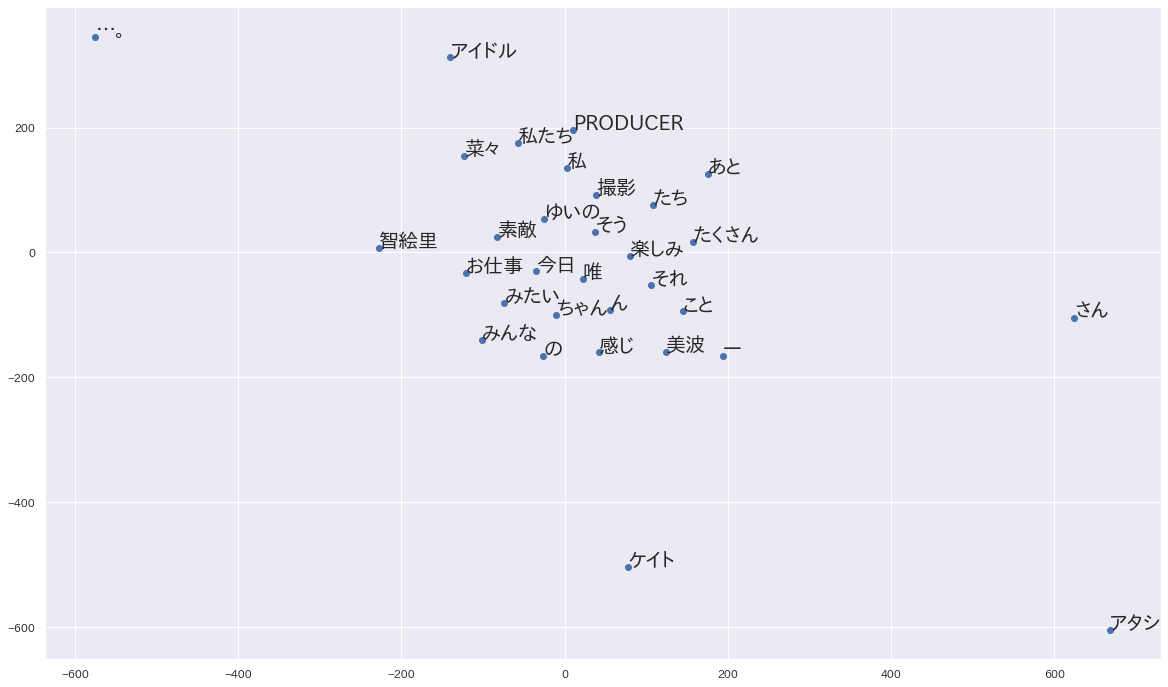

In [40]:
tsne = TSNE(random_state=428)
result = tsne.fit_transform(vecs)

plt.scatter(result[:,0], result[:,1], cmap=cm.tab10)

for i in range(len(result)):
    plt.annotate(labels[i],
                 xy=(result[i, 0]+0.1, result[i, 1]+0.1),
                 xytext=(0, 0),
                 textcoords='offset points')

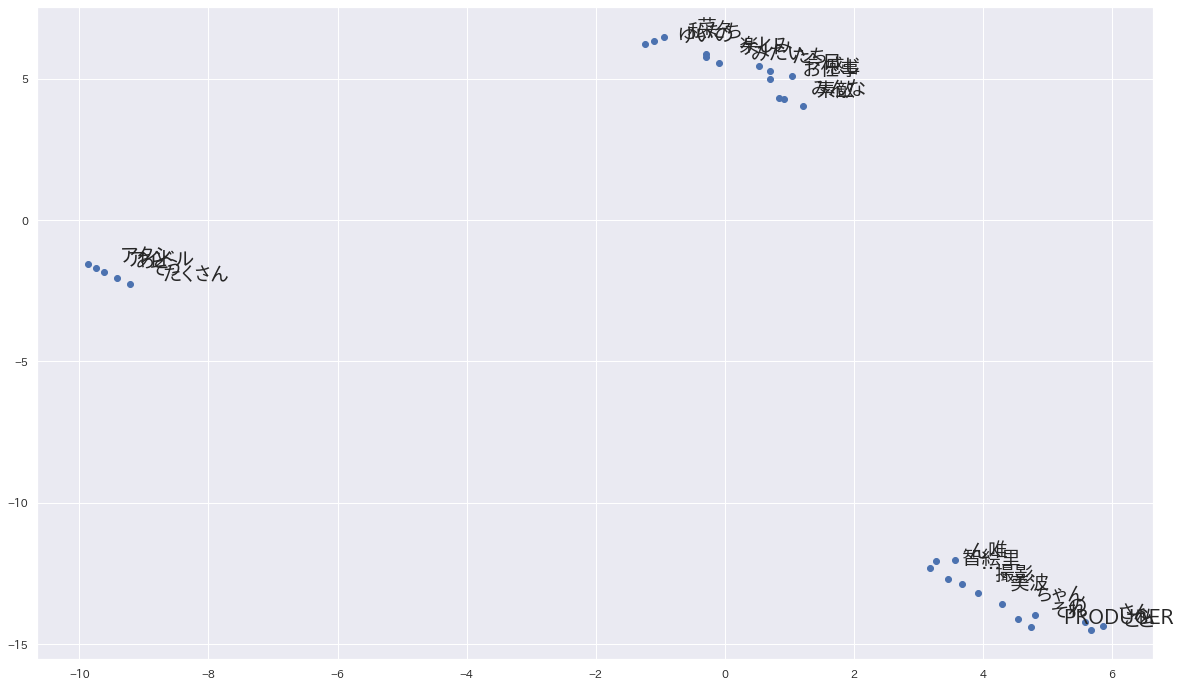

In [41]:
embedding = umap.UMAP(n_neighbors=5, random_state=428).fit_transform(vecs)

plt.scatter(embedding[:,0], embedding[:,1], cmap=cm.tab10)

for i in range(len(embedding)):
    plt.annotate(labels[i],
                 xy=(embedding[i, 0]+0.5, embedding[i, 1]+0.1),
                 xytext=(0, 0),
                 textcoords='offset points')

---

## TF-IDFの計算とLDAの計算

In [42]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# 折角計算したのでpickleに保存
import pickle
with open(f'./data/corpus_tfidf.dump', mode='wb') as f:
    pickle.dump(corpus_tfidf, f)

# 次回からはロードできます
# with open('./data/corpus_tfidf.dump', mode='rb') as f:
#     corpus_tfidf = pickle.load(f)

In [43]:
# 文書量にもよりますが、数時間程度かかったりもします。
# '18/12/03追記: LdaMulticore で worker の数を増やせばかなり早くなるかもです
lda = models.LdaModel(corpus=corpus_tfidf, id2word=dic,
                             num_topics=50, minimum_probability=0.001,
                             passes=20, update_every=0, chunksize=10000)
lda.save('./data/lda.model')  # 保存
#lda = gensim.models.LdaModel.load('./data/lda.model')  # 次回からロード可

In [44]:
lda.print_topic(10)

'0.083*"アイドル" + 0.062*"弱音" + 0.061*"緒方智絵里" + 0.027*"移動" + 0.022*"運勢" + 0.020*"トロフィー" + 0.019*"人前" + 0.016*"全国" + 0.015*"ビヨンド" + 0.014*"ちひろ"'

In [45]:
for i in range(10):
    print('tpc_{0}: {1}'.format(i, lda.print_topic(i)))

tpc_0: 0.071*"こちら" + 0.064*"ダンス" + 0.042*"歌" + 0.027*"袖" + 0.027*"印" + 0.020*"むこう" + 0.018*"ウサミン" + 0.015*"町屋" + 0.013*"レモン" + 0.012*"反省"
tpc_1: 0.088*"淹" + 0.079*"名刺" + 0.027*"方" + 0.015*"冷蔵庫" + 0.009*"リラックス" + 0.003*"丈夫" + 0.001*"ん" + 0.000*"声" + 0.000*"いかが" + 0.000*"ホットミルク"
tpc_2: 0.075*"明日" + 0.075*"服" + 0.049*"帰り" + 0.039*"幸運" + 0.024*"夏の思い出" + 0.020*"1番" + 0.016*"あと" + 0.014*"カフェラテ" + 0.013*"深呼吸して" + 0.012*"エステ"
tpc_3: 0.000*"ごら" + 0.000*"大反響" + 0.000*"つかさ" + 0.000*"琴歌" + 0.000*"三人" + 0.000*"三" + 0.000*"みなさま" + 0.000*"大発見" + 0.000*"レディス" + 0.000*"ムーディー"
tpc_4: 0.000*"ごら" + 0.000*"大反響" + 0.000*"つかさ" + 0.000*"琴歌" + 0.000*"三人" + 0.000*"三" + 0.000*"みなさま" + 0.000*"大発見" + 0.000*"レディス" + 0.000*"ムーディー"
tpc_5: 0.000*"ごら" + 0.000*"大反響" + 0.000*"つかさ" + 0.000*"琴歌" + 0.000*"三人" + 0.000*"三" + 0.000*"みなさま" + 0.000*"大発見" + 0.000*"レディス" + 0.000*"ムーディー"
tpc_6: 0.138*"衣装" + 0.105*"自覚" + 0.022*"お客さん" + 0.018*"それ" + 0.013*"セツ" + 0.013*"愛梨" + 0.013*"弱音" + 0.012*"友紀" + 0.007*"コントラスト" + 0.007*"動画"
tpc_7